# Template - Strategy - Backtesting 

### Import Library

In [146]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
from backtesting._plotting import set_bokeh_output
set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [147]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [148]:
data = dataset.copy()

In [149]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [150]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-07 14:15:00,1343.3,1344.4,1342.4,1344.2,5075
2025-02-07 14:20:00,1344.2,1344.7,1343.6,1344.0,4865
2025-02-07 14:25:00,1344.1,1344.2,1342.8,1343.3,5013


In [151]:
def cal_signal(r):
    signal = ''
    if  r['Open_s1'] < r['Close_s1'] < r['Close'] < r['High_s1'] and r['Close'] > r['Open'] and  r['Close'] > r['min_12'] + 3.1:
        signal = 'long'
    elif r['Open_s1'] > r['Close_s1'] > r['Close'] > r['Low_s1'] and r['Close'] < r['Open'] and  r['Close'] > r['max_12'] - 3.1:
        # 2 cay nen lien tiep deu la nen mau DO
        # gia dong cua cua cay nen SAU nam trong vung bong nen cua cay nen TRUOC
        # Gia giam so voi dinh 12 cay nen lien tiep ko qua 3 diem.
        signal = 'short'
    return signal

def prepare_data(data):
    data['Open_s1'] = data['Open'].shift(1)
    data['Close_s1'] = data['Close'].shift(1)
    data['High_s1'] = data['High'].shift(1)
    data['Low_s1'] = data['Low'].shift(1)
    data['min_12'] = data['Low'].rolling(12).min()
    data['max_12'] = data['High'].rolling(12).max()
    data['signal'] = data.apply(lambda r: cal_signal(r), axis=1)
    #
    data["current"] = data.index + pd.DateOffset(minutes=5)
    return data

In [152]:
class MainStrategy(Strategy):
    rr = 1.5
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
            return

        if self.position:
            return 
        signal = self.data.signal[-1]
        close_price = self.data.Close[-1]
        open_price = self.data.Open[-1]
        min_12 = self.data.min_12[-1]
        max_12 = self.data.max_12[-1]
        if signal == 'long':
            buy_price = close_price
            sl = min_12 - 0.1
            tp = buy_price + self.rr * (buy_price - sl)
            self.buy(size=1, sl=sl, tp=tp)
        elif signal == 'short':
            sell_price = close_price
            sl = max_12 + 0.1
            tp = sell_price - self.rr * (sl - sell_price)
            self.sell(size=1, sl=sl, tp=tp)

In [153]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [154]:
bt = Backtest(prepared_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [155]:
stats

Start                     2020-11-02 09:55:00
End                       2025-02-07 14:45:00
Duration                   1558 days 04:50:00
Exposure Time [%]                   29.358492
Equity Final [$]                   1303.59253
Equity Peak [$]                    1631.09929
Return [%]                         -13.093831
Buy & Hold Return [%]               49.040275
Return (Ann.) [%]                   -3.301733
Volatility (Ann.) [%]                7.636802
Sharpe Ratio                        -0.432345
Sortino Ratio                       -0.618321
Calmar Ratio                        -0.160404
Max. Drawdown [%]                  -20.583806
Avg. Drawdown [%]                   -0.927455
Max. Drawdown Duration     1337 days 01:40:00
Avg. Drawdown Duration       29 days 13:01:00
# Trades                                 1101
Win Rate [%]                        41.871026
Best Trade [%]                       3.566524
Worst Trade [%]                     -4.138348
Avg. Trade [%]                    

In [156]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,-1,33,33,901.22955,899.10,2.12955,0.002363,2020-11-02 14:05:00,2020-11-02 14:05:00,None,0 days 00:00:00
1,-1,44,56,908.22745,907.00,1.22745,0.001351,2020-11-03 09:20:00,2020-11-03 10:20:00,None,0 days 01:00:00
2,-1,67,69,909.02721,906.65,2.37721,0.002615,2020-11-03 11:15:00,2020-11-03 11:25:00,None,0 days 00:10:00
3,1,135,138,917.07504,912.00,-5.07504,-0.005534,2020-11-04 14:05:00,2020-11-04 14:20:00,None,0 days 00:15:00
4,1,157,190,916.47486,912.30,-4.17486,-0.004555,2020-11-05 10:15:00,2020-11-05 14:25:00,None,0 days 04:10:00
...,...,...,...,...,...,...,...,...,...,...,...
1096,1,51677,51724,1298.08931,1294.50,-3.58931,-0.002765,2024-11-22 09:10:00,2024-11-22 14:30:00,None,0 days 05:20:00
1097,1,51733,51775,1298.28937,1297.10,-1.18937,-0.000916,2024-11-25 09:35:00,2024-11-25 14:30:00,None,0 days 04:55:00
1098,1,53487,53499,1292.08751,1298.00,5.91249,0.004576,2025-01-13 13:25:00,2025-01-13 14:25:00,None,0 days 01:00:00
1099,1,53507,53518,1296.98898,1293.10,-3.88898,-0.002998,2025-01-14 09:25:00,2025-01-14 10:20:00,None,0 days 00:55:00


In [157]:
# bt.plot()

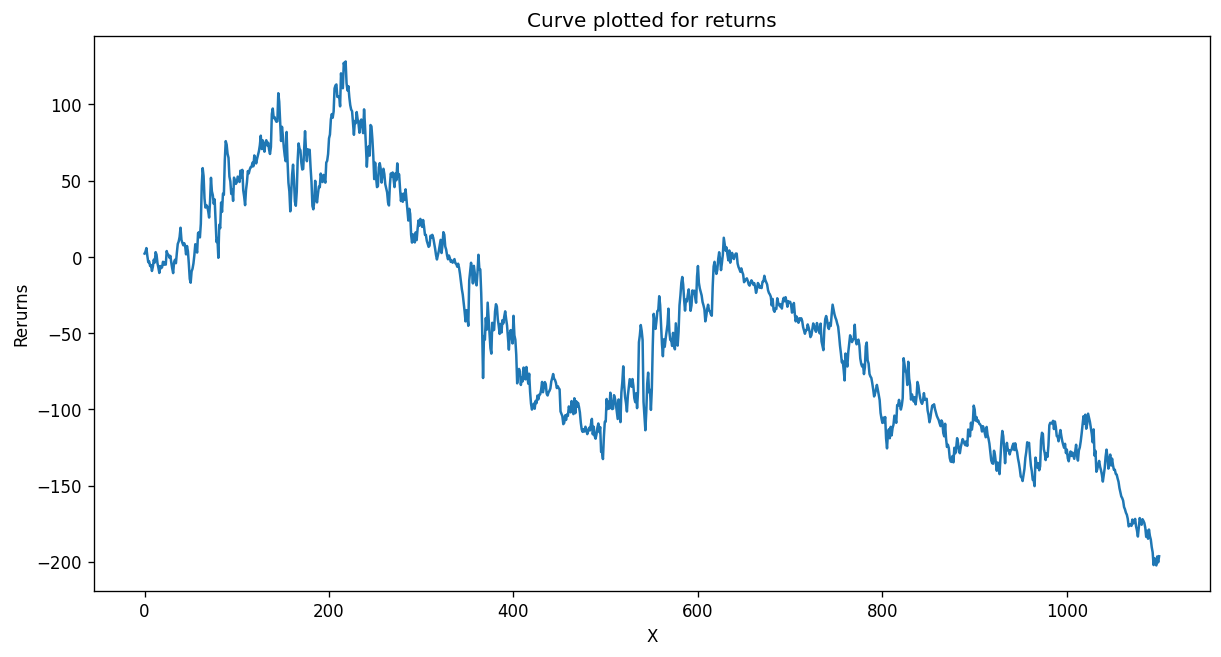

In [158]:
trades = stats['_trades']
copy_trades = trades.copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

# Analytics

In [159]:
join_trades = pd.merge(trades, prepared_data, left_on="EntryTime", right_on='current', how="left")
join_trades

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,...,Close,Volume,Open_s1,Close_s1,High_s1,Low_s1,min_12,max_12,signal,current
0,-1,33,33,901.22955,899.10,2.12955,0.002363,2020-11-02 14:05:00,2020-11-02 14:05:00,None,...,901.5,3062.0,902.5,902.0,902.9,901.1,896.3,903.0,short,2020-11-02 14:05:00
1,-1,44,56,908.22745,907.00,1.22745,0.001351,2020-11-03 09:20:00,2020-11-03 10:20:00,None,...,908.5,1355.0,908.8,908.6,908.8,908.2,896.6,909.4,short,2020-11-03 09:20:00
2,-1,67,69,909.02721,906.65,2.37721,0.002615,2020-11-03 11:15:00,2020-11-03 11:25:00,None,...,909.2,2070.0,910.5,909.3,910.6,909.1,906.8,910.8,short,2020-11-03 11:15:00
3,1,135,138,917.07504,912.00,-5.07504,-0.005534,2020-11-04 14:05:00,2020-11-04 14:20:00,None,...,916.7,5942.0,912.8,916.3,917.2,912.5,912.1,918.1,long,2020-11-04 14:05:00
4,1,157,190,916.47486,912.30,-4.17486,-0.004555,2020-11-05 10:15:00,2020-11-05 14:25:00,None,...,916.2,2015.0,915.3,916.0,916.3,915.2,912.4,916.3,long,2020-11-05 10:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,1,51677,51724,1298.08931,1294.50,-3.58931,-0.002765,2024-11-22 09:10:00,2024-11-22 14:30:00,None,...,1297.6,4878.0,1294.7,1296.6,1299.0,1292.7,1273.8,1299.0,long,2024-11-22 09:10:00
1097,1,51733,51775,1298.28937,1297.10,-1.18937,-0.000916,2024-11-25 09:35:00,2024-11-25 14:30:00,None,...,1297.8,2069.0,1296.6,1297.2,1297.9,1296.5,1292.2,1300.0,long,2024-11-25 09:35:00
1098,1,53487,53499,1292.08751,1298.00,5.91249,0.004576,2025-01-13 13:25:00,2025-01-13 14:25:00,None,...,1291.7,2892.0,1291.5,1291.6,1291.8,1290.8,1287.6,1292.5,long,2025-01-13 13:25:00
1099,1,53507,53518,1296.98898,1293.10,-3.88898,-0.002998,2025-01-14 09:25:00,2025-01-14 10:20:00,None,...,1296.8,2871.0,1295.4,1296.4,1297.4,1295.4,1293.2,1301.5,long,2025-01-14 09:25:00


In [160]:
join_trades[join_trades.EntryTime == '2025-02-06 13:35:00']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,...,Close,Volume,Open_s1,Close_s1,High_s1,Low_s1,min_12,max_12,signal,current
